# An example for PyXSPEC 

This is a simple example case for using PyXspec. You can find a detailed manual for the package [here](http://heasarc.nasa.gov/docs/xanadu/xspec/python/html/index.html). 

In this notebook, I use PyXspec to fit multiple X-ray spectra of a transient X-ray source (H 1658-298) obtained over the span of a few months by [Swift/XRT](http://www.swift.ac.uk/index.php) to study the evolution of the outburst (see XXXX). So, the goal of this example is to fit each of the obtained spectra individually with the same model and look for evolution in brightness and parameters in the spectral model.

In [1]:
from xspec import *

import numpy as np
import glob

from astropy.io import fits, ascii
from astropy.table import Table, vstack

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')
%matplotlib inline

Setting XSPEC configurations:

In [2]:
Xset.abund = "wilm"    # Abundance of elements
Xset.xsect = "vern"    # Cross-section
Fit.query = "yes"      # default response to XSpec queries
Fit.nIterations = 100  # fit iterations for each attemp
Plot.device = "/xs"    # plotting device, here set to Xwindows
Plot.xAxis = "KeV"     # X-axis for plotting set to energy instead of channel

Finding available spectra (based on previous naming convention) in this folder and making a list of them:

In [3]:
datalist=glob.glob('sw*bin*')
datalist

['sw00034002001xpcw3po_spec_src_bin50.pi',
 'sw00034002003xwtw2po_spec_src_bin50.pi',
 'sw00034002004xwtw2po_spec_seg1_src_bin50.pi',
 'sw00034002004xwtw2po_spec_seg2_src_bin50.pi',
 'sw00034002004xwtw2po_spec_seg3_src_bin50.pi',
 'sw00034002005xwtw2po_spec_seg1_src_bin50.pi',
 'sw00034002005xwtw2po_spec_seg2_src_bin50.pi',
 'sw00034002005xwtw2po_spec_seg3_src_bin50.pi',
 'sw00034002005xwtw2po_spec_seg4_src_bin50.pi',
 'sw00034002006xwtw2po_spec_src_bin100.pi',
 'sw00034002007xwtw2po_spec_src_bin100.pi',
 'sw00034002008xwtw2po_spec_seg1_src_bin50.pi',
 'sw00034002008xwtw2po_spec_seg2_src_bin50.pi',
 'sw00034002009xwtw2po_spec_src_bin100.pi']

I want to fit each spectrum individually and record best fit value of model parameters, uncertainties and fit statistics (e.g., to track spectral evolution). In this example I'm going to use Xspec's [pegpwrlw](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSmodelPegpwrlw.html) model. 

So I initiate empty lists to populate with fit results. Then with a `for` loop, I go through the spectra listed above and perform fitting and estimating uncertainties.

I will also use [astropy.io.fits](http://docs.astropy.org/en/stable/io/fits/) to read important keywords from spectrum file's header (e.g., observation ID, MJD, exposure) and use [astropy.table](http://docs.astropy.org/en/stable/table/) to tabulate results in a desirable foramt. Finally, I use matplotlib to plot the results.

In [4]:
# Initiating arrays to store data (best fit values and errors) for each spectrum

# Observation parameters:
obs_id = []          # observation id, to be read from fits header of each spectrum
mjd = []             # observation MJD, to be read from fits header of each spectrum
obs_exp = []         # observation exposure, to be read from fits header of each spectrum

# model parameters:
pw_nh = []           # hydrogen column density, NH
pw_nh_ler = []       # NH lower limit
pw_nh_uer = []       # NH upper limit
pw_gamma = []        # power law photon index, Gamma
pw_gamma_ler = []    # Gamma lower limit
pw_gamma_uer = []    # Gamma upper limit
pw_flx = []          # Powerlaw normalization, corresponding to flux
pw_flx_ler = []      # flux lower limit
pw_flx_uer = []      # flux upper limit

# Fit parameter
fit_chi2 = []        # fit's reduced chi-sqaured
fit_dof = []         # fit's degrees of freedom


# like Xspec, pyxspec produces significant terminal output. 
# It is useful to capture this and save it in a log file:
Xset.openLog("fit_log.txt")          

# The main loop for fitting:
for spec in datalist:
    # part 1: reading observation parameters:
    hdulist = fits.open(spec)                     # Reading the spectrum fits file to identify keywords in header
    obs_id.append(hdulist[0].header['OBS_ID'])    # Obs ID
    mjd.append(hdulist[0].header['MJD-OBS'])      # Obs MJD
    obs_exp.append(hdulist[0].header['EXPOSURE']) # Obs exposure
    
    # Part 2: pyXspec data preparation and fitting
    AllData(spec)                                    # Reading spectrum
    AllData.ignore('bad')                         # Ignore bad channels
    AllData.ignore('*:10.0-**')                   # Ignore channels above 10 keV

    # In this example, I'm using Swift data.
    # I want to ignore some channels based on observation mode (Fits header keyword 'DATAMODE')
    if hdulist[0].header['DATAMODE'] == 'PHOTON':
        AllData.ignore('*:**-0.3')
    if hdulist[0].header['DATAMODE'] == 'WINDOWED':
        AllData.ignore('*:**-0.5')

    # Model and parameters:
    m = Model('tbabs*pegpwrlw')                   # Setting Model
    # I want to modify some model parameters before fitting:
    # Parameter 3 in our model is powerlaw's lower peg energy range:
    AllModels(1)(3).values = [0.5]                # Setting parameter 3 to 0.5 keV
    AllModels(1)(3).frozen = True                 # Freez parameter 3
    
    # Performing the fit:
    Fit.perform()
    
    # Checking results and saving values:
    Plot('lda del')                               # Plotting the fit: data in log space 'lda' and residuals 'del' 
    
    # Now storing the best fit values for parameters:
    # You should be careful about units in Xspec model parameters:
    # E.g., here NH is in units of 1e22 cm^-2 and flux (pl normalization) is in units of 1e-12 erg/s/cm2
    pw_nh.append(AllModels(1)(1).values[0]*1e22)
    pw_gamma.append(AllModels(1)(2).values[0])
    pw_flx.append(AllModels(1)(5).values[0]*1e-12)
    fit_chi2.append(Fit.statistic/Fit.dof)
    fit_dof.append(Fit.dof)
    
    # Now estimating uncertainties:
    Fit.error('maximum 3 1-5')
    
    # Now 'error' attribute of model parameters are defined
    # So we can save upper and lower limits:
    pw_nh_ler.append((AllModels(1)(1).values[0]-AllModels(1)(1).error[0])*1e22)
    pw_nh_uer.append((AllModels(1)(1).error[1]-AllModels(1)(1).values[0])*1e22)
    pw_gamma_ler.append(AllModels(1)(2).values[0]-AllModels(1)(2).error[0])
    pw_gamma_uer.append(AllModels(1)(2).error[1]-AllModels(1)(2).values[0])
    pw_flx_ler.append((AllModels(1)(5).values[0]-AllModels(1)(5).error[0])*1e-12)
    pw_flx_uer.append((AllModels(1)(5).error[1]-AllModels(1)(5).values[0])*1e-12)
    
# Closing the log file
Xset.closeLog()

# Tabulating the results:
result=Table(data=[obs_id,mjd,pw_nh,pw_nh_ler,pw_nh_uer,pw_gamma,pw_gamma_ler,pw_gamma_uer,
                   pw_flx,pw_flx_ler,pw_flx_uer,fit_chi2,fit_dof],
             names=['Obs.ID','MJD','NH','NH_err-','NH_err+','gamma','gamma_err-','gamma_err+',
                    'flux','flux_err-','flux_err+','red_chi2','d.o.f'])

result.sort('MJD')
result.write('swift_xrt_monitoring.txt', format='ascii.tab')
result

Obs.ID,MJD,NH,NH_err-,NH_err+,gamma,gamma_err-,gamma_err+,flux,flux_err-,flux_err+,red_chi2,d.o.f
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
00034002001,57259.728801,4.00209063639e+21,5.78560217869e+20,6.644510245e+20,1.51160844541,0.0865901531459,0.0909020329509,7.11840661815e-10,2.92006420758e-11,2.95713009955e-11,1.13551092672,48
00034002003,57270.3546941,5.88830516923e+21,7.66567821999e+20,8.39519421305e+20,1.65605645209,0.0940700221224,0.0980281641584,1.14548781423e-09,4.59009550093e-11,4.72875537755e-11,0.972867159858,56
00034002004,57272.217,6.99685523332e+21,7.23806759474e+20,7.7393262251e+20,1.86478325437,0.0891379395455,0.0921836932857,1.11291951637e-09,4.2715593355e-11,4.56042678559e-11,1.04028647769,72
00034002004,57272.2831178,5.19746923242e+21,6.36079030014e+20,6.86929102894e+20,1.63391488422,0.0821424913333,0.0850361763419,1.10994403742e-09,3.77251939055e-11,3.84858465748e-11,1.18050724051,76
00034002004,57272.9477039,5.79459642627e+21,7.84095774475e+20,8.65423579408e+20,1.69794095869,0.0944444491538,0.0987033687823,9.0271500883e-10,3.70353195653e-11,3.87588408812e-11,1.54368912466,57
00034002005,57274.1674603,4.34948318665e+21,6.40224752866e+20,6.89643989621e+20,1.66625784713,0.0888955653905,0.092080712762,9.76239046248e-10,3.82731147183e-11,3.90024431403e-11,1.23440499664,58
00034002005,57274.222315,3.36027697937e+21,5.40152187234e+20,5.86160164697e+20,1.46991869952,0.084977029505,0.0878985361527,9.70228435072e-10,3.83982279826e-11,3.88570438369e-11,0.962302964439,56
00034002005,57274.288984,3.25189332418e+21,7.77303348651e+20,8.4879902434e+20,1.42106202049,0.115549382303,0.119788913095,6.11533167237e-10,3.20647106851e-11,3.2778066907e-11,1.19124524499,34
00034002005,57274.4195394,4.26731085103e+21,5.78457078804e+20,6.19020106964e+20,1.65372395533,0.0836797848524,0.086551753079,9.65953601155e-10,3.46321818669e-11,3.51146927368e-11,0.883367885145,65


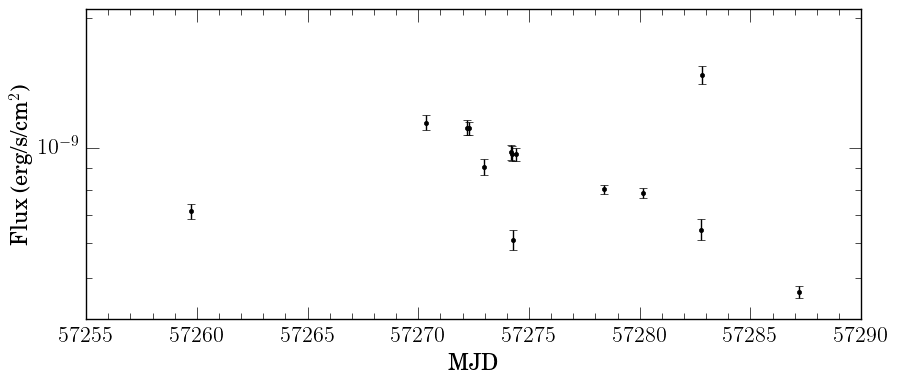

In [5]:
plt.figure(figsize=(10,4))
plt.errorbar(mjd,pw_flx,[pw_flx_ler,pw_flx_uer],fmt='.k')
plt.yscale('log')
plt.ylim(4e-10,2.1e-9)
plt.ylabel('Flux (erg/s/cm$^2$)',fontsize=16)
plt.xlabel('MJD', fontsize=16)
plt.ticklabel_format(axis='x',style='plain' ,useOffset=False)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)